加载包和数据，文件是txt，用read_table方法打开，因为原始数据不包含表头，所以需要赋予。字符串是空格分割，用\s+表示匹配任意空白符

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

In [353]:
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_table('CDNOW_master.txt',names = columns,sep= '\s+')

In [354]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


观察数据，order_dt表示时间，但现在它只是年月日组合的一串数字，没有时间含义。购买金额是小数。值得注意的是，一个用户在一天内可能购买多次，用户ID为2的用户就在1月12日买了两次，这个细节不要遗漏。

In [355]:
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


用户平均每笔订单购买2.4个商品，标准差在2.3，稍稍具有波动性。中位数在2个商品，75分位数在3个商品，说明绝大部分订单的购买量都不多。最大值在99个，数字比较高。购买金额的情况差不多，大部分订单都集中在小额。一般而言，消费类的数据分布，都是长尾形态。大部分用户都是小额，然而小部分用户贡献了收入的大头，俗称二八。

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [357]:
df['order_date']=pd.to_datetime(df.order_dt,format="%Y%m%d")

In [358]:
df['month']=df.order_date.values.astype('datetime64[M]')

pd.to_datetime可以将特定的字符串或者数字转换成时间格式，其中的format参数用于匹配。例如19970101，%Y匹配前四位数字1997，如果y小写只匹配两位数字97，%m匹配01，%d匹配01。

另外，小时是%h，分钟是%M，注意和月的大小写不一致，秒是%s。若是1997-01-01这形式，则是%Y-%m-%d，以此类推。

astype也可以将时间格式进行转换，比如[M]转化成月份。我们将月份作为消费行为的主要事件窗口，选择哪种时间窗口取决于消费频率

In [359]:
df.head()

,user_id,order_dt,order_products,order_amount,order_date,month
0,1,19970101,1,11.77,1997-01-01,1997-01-01
1,2,19970112,1,12.00,1997-01-12,1997-01-01
2,2,19970112,5,77.00,1997-01-12,1997-01-01
3,3,19970102,2,20.76,1997-01-02,1997-01-01
4,3,19970330,2,20.76,1997-03-30,1997-03-01


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         69659 non-null  int64         
 1   order_dt        69659 non-null  int64         
 2   order_products  69659 non-null  int64         
 3   order_amount    69659 non-null  float64       
 4   order_date      69659 non-null  datetime64[ns]
 5   month           69659 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 3.2 MB


In [361]:
user_grouped=df.groupby('user_id').sum()
user_grouped.head()

,order_dt,order_products,order_amount
user_id,,,
1,19970101,1,11.77
2,39940224,6,89.00
3,119833602,16,156.46
4,79882233,7,100.50
5,219686137,29,385.61


In [362]:
user_grouped.describe()

,order_dt,order_products,order_amount
count,2.357000e+04,23570.000000,23570.000000
mean,5.902627e+07,7.122656,106.080426
std,9.460684e+07,16.983531,240.925195
min,1.997010e+07,1.000000,0.000000
25%,1.997021e+07,1.000000,19.970000
50%,1.997032e+07,3.000000,43.395000
75%,5.992125e+07,7.000000,106.475000
max,4.334408e+09,1033.000000,13990.930000


从用户角度看，每位用户平均购买7张CD，最多的用户购买了1033张，属于狂热用户了。用户的平均消费金额（客单价）100元，标准差是240，结合分位数和最大值看，平均值才和75分位接近，肯定存在小部分的高额消费用户。

接下来按月的维度分析。

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
Name: order_amount, dtype: float64

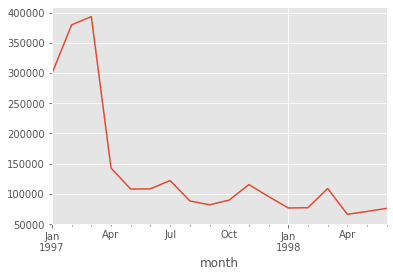

In [363]:
df.groupby('month').order_amount.sum().plot()
df.groupby('month').order_amount.sum().head()

按月统计每个月的CD销量。从图中可以看到，前几个月的销量非常高涨。数据比较异常。而后期的销量则很平稳。

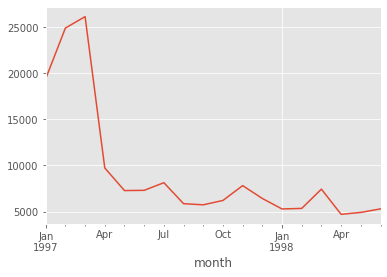

In [364]:
df.groupby('month').order_products.sum().plot()

金额一样呈现早期销售额多，后期平稳下降的趋势。为什么会呈现这个原因呢？我们假设是用户身上出了问题，早期时间段的用户中有异常值，第二假设是各类促销营销，但这里只有消费数据，所以无法判断。

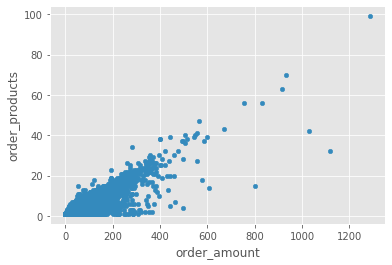

In [365]:
df.plot.scatter(x='order_amount',y='order_products')

绘制每笔订单的散点图。从图中观察，订单消费金额和订单商品量呈规律性，每个商品十元左右。订单的极值较少，超出1000的就几个。显然不是异常波动的罪魁祸首。

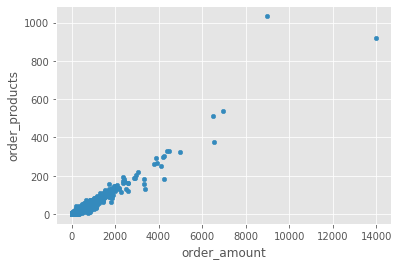

In [366]:
df.groupby('user_id').sum().plot.scatter(x='order_amount',y='order_products')

绘制用户的散点图，用户也比较健康，而且规律性比订单更强。因为这是CD网站的销售数据，商品比较单一，金额和商品量的关系也因此呈线性，没几个离群点。

消费能力特别强的用户有，但是数量不多。为了更好的观察，用直方图。

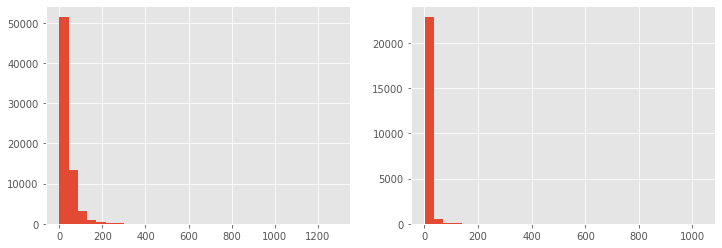

In [367]:
plt.figure(figsize=(12,4))
plt.subplot(121)
df.order_amount.hist(bins=30)
plt.subplot(122)
df.groupby('user_id').sum().order_products.hist(bins=30)

plt.subplot用于绘制子图，子图用数字参数表示。121表示分成1*2个图片区域，占用第一个，即第一行第一列，122表示占用第二个。figure是尺寸函数，为了容纳两张子图，宽设置的大一点即可。

从直方图看，大部分用户的消费能力确实不高，高消费用户在图上几乎看不到。这也确实符合消费行为的行业规律。

观察完用户消费的金额和购买量，接下来看消费的时间节点。

In [368]:
df.groupby('user_id').month.min().value_counts()

1997-02-01    8476
1997-01-01    7846
1997-03-01    7248
Name: month, dtype: int64

用groupby函数将用户分组，并且求月份的最小值，最小值即用户消费行为中的第一次消费时间。ok，结果出来了，所有用户的第一次消费都集中在前三个月。我们可以这样认为，案例中的订单数据，只是选择了某个时间段消费的用户在18个月内的消费行为。

In [369]:
df.groupby('user_id').month.max().value_counts()

1997-02-01    4912
1997-03-01    4478
1997-01-01    4192
1998-06-01    1506
1998-05-01    1042
1998-03-01     993
1998-04-01     769
1997-04-01     677
1997-12-01     620
1997-11-01     609
1998-02-01     550
1998-01-01     514
1997-06-01     499
1997-07-01     493
1997-05-01     480
1997-10-01     455
1997-09-01     397
1997-08-01     384
Name: month, dtype: int64

观察用户的最后一次消费时间。绝大部分数据依然集中在前三个月。后续的时间段内，依然有用户在消费，但是缓慢减少。

异常趋势的原因获得了解释，现在针对消费数据进一步细分。我们要明确，这只是部分用户的订单数据，所以有一定局限性。在这里，我们统一将数据上消费的用户定义为新客。

接下来分析消费中的复购率和回购率。首先将用户消费数据进行数据透视

In [370]:
pivoted_counts=df.pivot_table(index='user_id',columns='month',
                              values='order_dt',aggfunc='count').fillna(0)
columns_month=df.month.sort_values(ascending=True).astype('str').unique()
pivoted_counts.columns=columns_month
pivoted_counts.head()


,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


在pandas中，数据透视有专门的函数pivot_table，功能非常强大。pivot_table参数中，index是设置数据透视后的索引，column是设置数据透视后的列，简而言之，index是你想要的行，column是想要的列。案例中，我希望统计每个用户在每月的订单量，所以user_id是index，month是column。

values是将哪个值进行计算，aggfunc是用哪种方法。于是这里用values=order_dt和aggfunc=count，统计里order_dt出现的次数，即多少笔订单。
使用数据透视表，需要明确获得什么结果。有些用户在某月没有进行过消费，会用NaN表示，这里用fillna填充。

生成的数据透视，月份是1997-01-01 00:00:00表示，比较丑。将其优化成标准格式。

首先求复购率，复购率的定义是在某时间窗口内消费两次及以上的用户在总消费用户中占比。这里的时间窗口是月，如果一个用户在同一天下了两笔订单，这里也将他算作复购用户。

将数据转换一下，消费两次及以上记为1，消费一次记为0，没有消费记为NaN。

In [371]:
pivoted_counts_transf=pivoted_counts.applymap(lambda x: 1 if x>1 else np.NaN if x== 0 else 0)
pivoted_counts_transf

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23566,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23567,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23568,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


applymap针对DataFrame里的所有数据。用lambda进行判断，因为这里涉及了多个结果，所以要两个if else，记住，lambda没有elif的用法

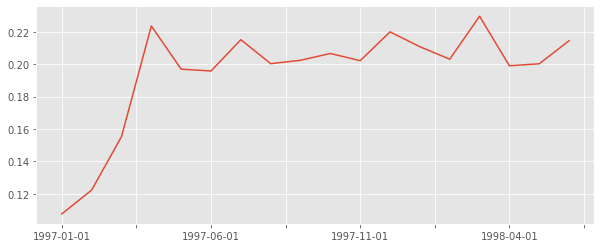

In [372]:
(pivoted_counts_transf.sum()/pivoted_counts_transf.count()).plot(figsize=(10,4))

用sum和count相除即可计算出复购率。因为这两个函数都会忽略NaN，而NaN是没有消费的用户，count不论0还是1都会统计，所以是总的消费用户数，而sum求和计算了两次以上的消费用户。这里用了比较巧妙的替代法计算复购率，SQL中也可以用。

图上可以看出复购率在早期，因为大量新用户加入的关系，新客的复购率并不高，譬如1月新客们的复购率只有6%左右。而在后期，这时的用户都是大浪淘沙剩下的老客，复购率比较稳定，在20%左右。

单看新客和老客，复购率有三倍左右的差距。

接下来计算回购率。回购率是某一个时间窗口内消费的用户，在下一个时间窗口仍旧消费的占比。我1月消费用户1000，他们中有300个2月依然消费，回购率是30%。

回购率的计算比较难，因为它设计了横向跨时间窗口的对比。

In [373]:
pivoted_amount=df.pivot_table(index='user_id',columns='month',
                              values='order_amount',aggfunc='mean').fillna(0)
columns_month=df.month.sort_values().astype('str').unique()
pivoted_amount.columns=columns_month
pivoted_amount.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,11.77,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
2,44.50,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.00,0.0
3,20.76,0.0,20.76,19.54,0.00,0.00,0.00,0.00,0.00,0.0,39.205,0.000,0.00,0.0,0.0,0.0,16.99,0.0
4,29.53,0.0,0.00,0.00,0.00,0.00,0.00,14.96,0.00,0.0,0.000,26.480,0.00,0.0,0.0,0.0,0.00,0.0
5,21.65,38.9,0.00,45.55,38.71,26.14,28.14,0.00,40.47,0.0,0.000,43.465,37.47,0.0,0.0,0.0,0.00,0.0


将消费金额进行数据透视，这里作为练习，使用了平均值。

In [374]:
pivoted_purchase=pivoted_amount.applymap(lambda x: 1 if x>0 else 0)
pivoted_purchase.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


再次用applymap+lambda转换数据，只要有过购买，记为1，反之为0。

In [375]:
def purchase_return(data):
    status=[]
    for i in range(17):
        if data[i]==1:
            if data[i+1]==1:
                status.append(1)
            if data[i+1]==0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    
    return pd.Series(status,index =columns_month)    
   
pivoted_purchase_return=pivoted_purchase.apply(purchase_return,axis=1)
pivoted_purchase_return

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23566,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23567,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23568,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


新建一个判断函数。data是输入的数据，即用户在18个月内是否消费的记录，status是空列表，后续用来保存用户是否回购的字段。

因为有18个月，所以每个月都要进行一次判断，需要用到循环。if的主要逻辑是，如果用户本月进行过消费，且下月消费过，记为1，没有消费过是0。本月若没有进行过消费，为NaN，后续的统计中进行排除。

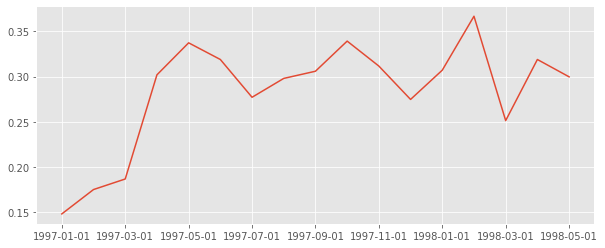

In [376]:
(pivoted_purchase_return.sum()/pivoted_purchase_return.count()).plot(figsize=(10,4))

最后的计算和复购率大同小异，用count和sum求出。从图中可以看出，用户的回购率高于复购，约在30%左右，波动性也较强。新用户的回购率在15%左右，和老客差异不大。

将回购率和复购率综合分析，可以得出，新客的整体质量低于老客，老客的忠诚度（回购率）表现较好，消费频次稍次，这是CDNow网站的用户消费特征。

接下来进行用户分层，我们按照用户的消费行为，简单划分成几个维度：新用户、活跃用户、不活跃用户、回流用户。

新用户的定义是第一次消费。活跃用户即老客，在某一个时间窗口内有过消费。不活跃用户则是时间窗口内没有消费过的老客。回流用户是在上一个窗口中没有消费，而在当前时间窗口内有过消费。以上的时间窗口都是按月统计。

比如某用户在1月第一次消费，那么他在1月的分层就是新用户；他在2月消费过，则是活跃用户；3月没有消费，此时是不活跃用户；4月再次消费，此时是回流用户，5月还是消费，是活跃用户。

分层会涉及到比较复杂的逻辑判断

In [377]:
def active_status(data):
    status=[]
    for i in range(18):
        
         #若本月没有消费
        if data[i]==0:
            if len(status)>0:
                if status[i-1]=='unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
        #若本月消费
        else:
            if len(status)==0:
                status.append('new')
            else:
                
                if status[i-1]=='unactive':
                    status.append('return')
                elif status[i-1]=='unreg':
                    status.append('new')
                else:
                    status.append('active')
    #return status
    return pd.Series(status,index =columns_month)

pivoted_purchase_status=pivoted_purchase.apply(lambda x: active_status(x),axis=1)
pivoted_purchase_status.head(100)  

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,new,active,active,active,unactive,return,active,active,unactive,return,active,active,active,active,active,unactive,return,active
97,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,active,unactive,unactive,unactive
98,new,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive


函数写得比较复杂，主要分为两部分的判断，以本月是否消费为界。本月没有消费，还要额外判断他是不是新客，因为部分用户是3月份才消费成为新客，那么在1、2月份他应该连新客都不是，用unreg表示。如果是老客，则为unactive。

本月若有消费，需要判断是不是第一次消费，上一个时间窗口有没有消费。大家可以多调试几次理顺里面的逻辑关系，对用户进行分层，逻辑确实不会简单，而且这里只是简化版本的。

从结果看，用户每个月的分层状态以及变化已经被我们计算出来。我是根据透视出的宽表计算，其实还有一种另外一种写法，只提取时间窗口内的数据和上个窗口对比判断，封装成函数做循环，它适合ETL的增量更新

In [378]:
purchase_status_counts=pivoted_purchase_status.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_status_counts

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1155.0,1680,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624,632.0,512.0,472.0,569.0,517.0,458.0,446.0
new,7814.0,8455.0,7231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1402,1232.0,1025.0,1079.0,1489.0,919.0,1030.0,1060.0
unactive,NaN,6659.0,13994,20678.0,21286.0,21161.0,21320.0,21728.0,21761.0,21661.0,21474,21638.0,21965.0,21951.0,21444.0,22066.0,22014.0,21996.0


unreg状态排除掉，它是「未来」才作为新客，这么能计数呢。换算成不同分层每月的统计量。

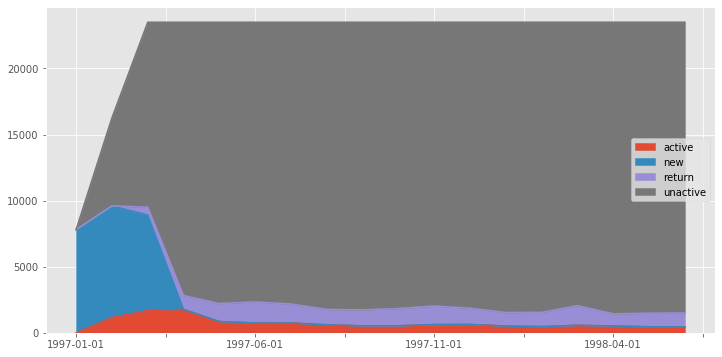

In [379]:
purchase_status_counts.fillna(0).T.plot.area(figsize=(12,6))

生成面积图，比较丑。因为它只是某时间段消费过的用户的后续行为，蓝色和灰色区域都可以不看。只看紫色回流和红色活跃这两个分层，用户数比较稳定。这两个分层相加，就是消费用户占比（后期没新客）。

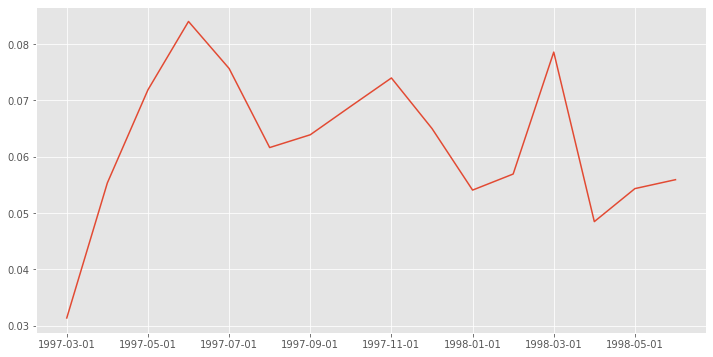

In [380]:
return_data=purchase_status_counts.apply(lambda x:x / x.sum(),axis=1)
return_data.loc['return'].plot(figsize=(12,6))

用户回流占比在5%～8%，有下降趋势。所谓回流占比，就是回流用户在总用户中的占比。另外一种指标叫回流率，指上个月多少不活跃/消费用户在本月活跃/消费。因为不活跃的用户总量近似不变，所以这里的回流率也近似回流占比。

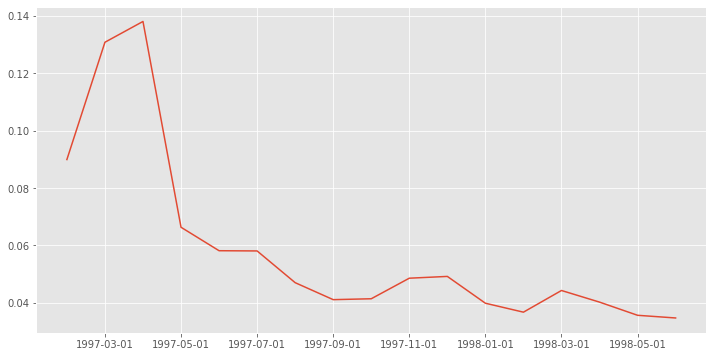

In [381]:
return_data.loc['active'].plot(figsize=(12,6))

活跃用户的下降趋势更明显，占比在3%～5%间。这里用户活跃可以看作连续消费用户，质量在一定程度上高于回流用户。

结合回流用户和活跃用户看，在后期的消费用户中，60%是回流用户，40%是活跃用户/连续消费用户，整体质量还好，但是针对这两个分层依旧有改进的空间，可以继续细化数据。

接下来分析用户质量，因为消费行为有明显的二八倾向，我们需要知道高质量用户为消费贡献了多少份额

In [382]:
user_amount=df.groupby('user_id').order_amount.sum().sort_values().reset_index()
user_amount['amount_cumsum']=user_amount.order_amount.cumsum()
user_amount.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


新建一个对象，按用户的消费金额生序。使用cumsum，它是累加函数。逐行计算累计的金额，最后的2500315便是总消费额

In [412]:
amount_total=user_amount.amount_cumsum.max()
user_amount['prop']=user_amount.apply(lambda x:x.amount_cumsum/amount_total,axis=1)
user_amount.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


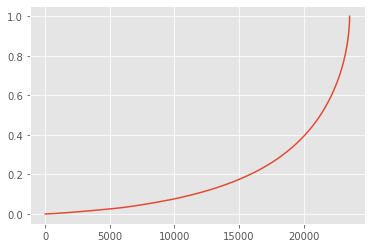

In [384]:
user_amount.prop.plot()#转成百分比

绘制趋势图，横坐标是按贡献金额大小排序而成，纵坐标则是用户累计贡献。可以很清楚的看到，前20000个用户贡献了40%的消费。后面4000位用户贡献了60%，确实呈现28倾向

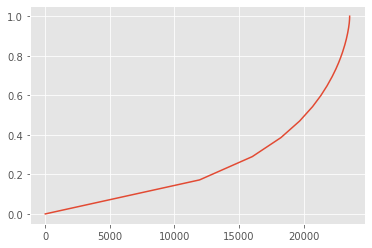

In [385]:
user_counts=df.groupby('user_id').order_dt.count().sort_values().reset_index()
user_counts['counts_cumsum']=user_counts.order_dt.cumsum()
counts_total=user_counts.counts_cumsum.max()
user_counts['prop']=user_counts.apply(lambda x:x.counts_cumsum/counts_total,axis=1)
user_counts.prop.plot()

统计一下销量，前两万个用户贡献了45%的销量，高消费用户贡献了55%的销量。在消费领域中，狠抓高质量用户是万古不变的道理。

接下来计算用户生命周期，这里定义第一次消费至最后一次消费为整个用户生命

In [386]:
user_purchase=df[['user_id','order_products','order_amount','order_date']]
order_date_min=user_purchase.groupby('user_id').order_date.min()
order_date_max=user_purchase.groupby('user_id').order_date.max()

In [387]:
(order_date_max-order_date_min).head(10)

user_id
1      0 days
2      0 days
3    511 days
4    345 days
5    367 days
6      0 days
7    445 days
8    452 days
9    523 days
10     0 days
Name: order_date, dtype: timedelta64[ns]

统计出用户第一次消费和最后一次消费的时间，相减，得出每一位用户的生命周期。因为数据中的用户都是前三个月第一次消费，所以这里的生命周期代表的是1月～3月用户的生命周期。因为用户会持续消费，所以理论上，随着后续的消费，用户的平均生命周期会增长

In [388]:
(order_date_max-order_date_min).mean()

Timedelta('134 days 20:55:36.987696')

求一下平均，所有用户的平均生命周期是134天，比预想的高，但是平均数不靠谱，还是看一下分布吧，大家有兴趣可以用describe，更详细。

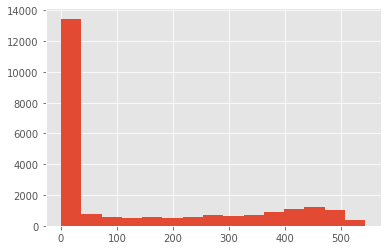

In [389]:
((order_date_max-order_date_min)/np.timedelta64(1,'D')).hist(bins=15)

因为这里的数据类型是timedelta时间，它无法直接作出直方图，所以先换算成数值。换算的方式直接除timedelta函数即可，这里的np.timedelta64(1, 'D')，D表示天，1表示1天，作为单位使用的。因为max-min已经表示为天了，两者相除就是周期的天数。
看到了没有，大部分用户只消费了一次，所有生命周期的大头都集中在了0天。但这不是我们想要的答案，不妨将只消费了一次的新客排除，来计算所有消费过两次以上的老客的生命周期

In [390]:
life_time=(order_date_max-order_date_min).reset_index()
life_time.head()

,user_id,order_date
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days


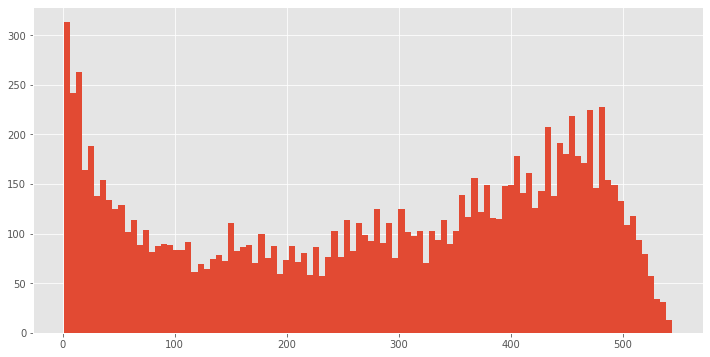

In [391]:
life_time['life_time']=life_time.order_date/np.timedelta64(1,'D')
life_time[life_time.life_time > 0].life_time.hist(bins=100,figsize=(12,6))

筛选出lifetime>0，即排除了仅消费了一次的那些人。做直方图。

这个图比上面的靠谱多了，虽然仍旧有不少用户生命周期靠拢在0天。这是双峰趋势图。部分质量差的用户，虽然消费了两次，但是仍旧无法持续，在用户首次消费30天内应该尽量引导。少部分用户集中在50天～300天，属于普通型的生命周期，高质量用户的生命周期，集中在400天以后，这已经属于忠诚用户了，大家有兴趣可以跑一下400天+的用户占老客比多少，占总量多少。

In [392]:
life_time[life_time.life_time > 0].life_time.mean()

276.0448072247308

消费两次以上的用户生命周期是276天，远高于总体。从策略看，用户首次消费后应该花费更多的引导其进行多次消费，提供生命周期，这会带来2.5倍的增量。

再来计算留存率，留存率也是消费分析领域的经典应用。它指用户在第一次消费后，有多少比率进行第二次消费。和回流率的区别是留存倾向于计算第一次消费，并且有多个时间窗口。

In [393]:
user_purchase_retention=pd.merge(left=user_purchase,right=order_date_min.reset_index(),how='inner',on='user_id',suffixes=('', '_min'))
user_purchase_retention.head()

,user_id,order_products,order_amount,order_date,order_date_min
0,1,1,11.77,1997-01-01,1997-01-01
1,2,1,12.00,1997-01-12,1997-01-12
2,2,5,77.00,1997-01-12,1997-01-12
3,3,2,20.76,1997-01-02,1997-01-02
4,3,2,20.76,1997-03-30,1997-01-02


这里用到merge函数，它和SQL中的join差不多，用来将两个DataFrame进行合并。我们选择了inner 的方式，对标inner join。即只合并能对应得上的数据。这里以on=user_id为对应标准。这里merge的目的是将用户消费行为和第一次消费时间对应上，形成一个新的DataFrame。suffxes参数是如果合并的内容中有重名column，加上后缀。除了merge，还有join，concat，用户接近，查看文档即可。

In [394]:
user_purchase_retention['order_date_diff']=user_purchase_retention.order_date-user_purchase_retention.order_date_min
user_purchase_retention.head()

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff
0,1,1,11.77,1997-01-01,1997-01-01,0 days
1,2,1,12.00,1997-01-12,1997-01-12,0 days
2,2,5,77.00,1997-01-12,1997-01-12,0 days
3,3,2,20.76,1997-01-02,1997-01-02,0 days
4,3,2,20.76,1997-03-30,1997-01-02,87 days


这里将order_date和order_date_min相减。获得一个新的列，为用户每一次消费距第一次消费的时间差值。

In [395]:
data_trans=lambda x:x/np.timedelta64(1,'D')
user_purchase_retention['date_diff']=user_purchase_retention.order_date_diff.apply(data_trans)
user_purchase_retention.head(10)

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0
5,3,2,19.54,1997-04-02,1997-01-02,90 days,90.0
6,3,5,57.45,1997-11-15,1997-01-02,317 days,317.0
7,3,4,20.96,1997-11-25,1997-01-02,327 days,327.0
8,3,1,16.99,1998-05-28,1997-01-02,511 days,511.0
9,4,2,29.33,1997-01-01,1997-01-01,0 days,0.0


In [396]:
bin=[0,3,7,15,30,60,90,180,365]
user_purchase_retention['date_diff_bin']=pd.cut(user_purchase_retention.date_diff,bins=bin)
user_purchase_retention.head(10)

,user_id,order_products,order_amount,order_date,order_date_min,order_date_diff,date_diff,date_diff_bin
0,1,1,11.77,1997-01-01,1997-01-01,0 days,0.0,NaN
1,2,1,12.00,1997-01-12,1997-01-12,0 days,0.0,NaN
2,2,5,77.00,1997-01-12,1997-01-12,0 days,0.0,NaN
3,3,2,20.76,1997-01-02,1997-01-02,0 days,0.0,NaN
4,3,2,20.76,1997-03-30,1997-01-02,87 days,87.0,"(60.0, 90.0]"
5,3,2,19.54,1997-04-02,1997-01-02,90 days,90.0,"(60.0, 90.0]"
6,3,5,57.45,1997-11-15,1997-01-02,317 days,317.0,"(180.0, 365.0]"
7,3,4,20.96,1997-11-25,1997-01-02,327 days,327.0,"(180.0, 365.0]"
8,3,1,16.99,1998-05-28,1997-01-02,511 days,511.0,NaN
9,4,2,29.33,1997-01-01,1997-01-01,0 days,0.0,NaN


将时间差值分桶。我这里分成0～3天内，3～7天内，7～15天等，代表用户当前消费时间距第一次消费属于哪个时间段呢。这里date_diff=0并没有被划分入0～3天，因为计算的是留存率，如果用户仅消费了一次，留存率应该是0。另外一方面，如果用户第一天内消费了多次，但是往后没有消费，也算作留存率0。

In [397]:
pivoted_retention=user_purchase_retention.pivot_table(index='user_id',columns='date_diff_bin',values='order_amount',aggfunc=sum,dropna=False)
#user_purchase_retention['date_diff_bin'] = user_purchase_retention['date_diff_bin'].astype('str')
pivoted_retention.head(10)

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,40.3,NaN,78.41
4,NaN,NaN,NaN,29.73,NaN,NaN,NaN,41.44
5,NaN,NaN,13.97,NaN,38.90,NaN,110.40,155.54
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.43
8,NaN,NaN,NaN,NaN,13.97,NaN,45.29,104.17
9,NaN,NaN,NaN,NaN,NaN,NaN,30.33,NaN


用pivot_table数据透视，获得的结果是用户在第一次消费之后，在后续各时间段内的消费总额

In [398]:
pivoted_retention.mean()

date_diff_bin
(0, 3]        35.905798
(3, 7]        36.385121
(7, 15]       42.669895
(15, 30]      45.964649
(30, 60]      50.215070
(60, 90]      48.975277
(90, 180]     67.223297
(180, 365]    91.960059
dtype: float64

计算一下用户在后续各时间段的平均消费额，这里只统计有消费的平均值。虽然后面时间段的金额高，但是它的时间范围也宽广。从平均效果看，用户第一次消费后的0～3天内，更可能消费更多。

但消费更多是一个相对的概念，我们还要看整体中有多少用户在0～3天消费。

In [399]:
pivoted_retention_trans=pivoted_retention.fillna(0).applymap(lambda x:1 if x>0 else 0)
pivoted_retention_trans.head()

date_diff_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
user_id,,,,,,,,
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,1
5,0,0,1,0,1,0,1,1


依旧将数据转换成是否，1代表在该时间段内有后续消费，0代表没有。

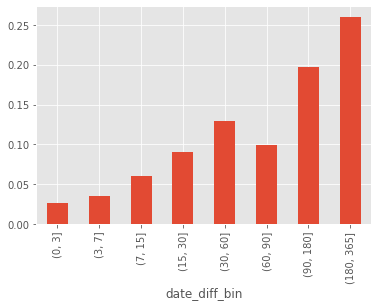

In [400]:
(pivoted_retention_trans.sum()/23570).plot.bar()
#(pivoted_retention_trans.sum()/pivoted_retention_trans.count()).plot.bar()

只有2.5%的用户在第一次消费的次日至3天内有过消费，3%的用户在3～7天内有过消费。数字并不好看，CD购买确实不是高频消费行为。时间范围放宽后数字好看了不少，有20%的用户在第一次消费后的三个月到半年之间有过购买，27%的用户在半年后至1年内有过购买。从运营角度看，CD机营销在教育新用户的同时，应该注重用户忠诚度的培养，放长线掉大鱼，在一定时间内召回用户购买。

怎么算放长线掉大鱼呢？我们计算出用户的平均购买周期。

In [401]:
grouped=user_purchase_retention.groupby('user_id')
i=0
for user,group in grouped:
    print(group)
    i+=1
    if i==2:
        break

   user_id  order_products  order_amount order_date order_date_min  \
0        1               1         11.77 1997-01-01     1997-01-01   

  order_date_diff  date_diff date_diff_bin  
0          0 days        0.0           NaN  
   user_id  order_products  order_amount order_date order_date_min  \
1        2               1          12.0 1997-01-12     1997-01-12   
2        2               5          77.0 1997-01-12     1997-01-12   

  order_date_diff  date_diff date_diff_bin  
1          0 days        0.0           NaN  
2          0 days        0.0           NaN  


我们将用户分组，groupby分组后的数据，也是能用for进行循环和迭代的。第一个循环对象user，是分组的对象，即user_id；第二个循环对象group，是分组聚合后的结果。为了举例我用了print，它依次输出了user_id=1,user_id=2时的用户消费数据，是一组切割后的DataFrame。

大家应该了解分组循环的用法，但是网不建议大家用for循环，它的效率非常慢。要计算用户的消费间隔，确实需要用户分组，但是用apply效率更快。

In [402]:
def diff(group):
    d=group.date_diff.shift(-1)-group.date_diff
    return d
last_diff=user_purchase_retention.groupby('user_id').apply(diff)
last_diff

user_id       
1        0         NaN
2        1         0.0
         2         NaN
3        3        87.0
         4         3.0
                  ... 
23568    69654    17.0
         69655     NaN
23569    69656     NaN
23570    69657     1.0
         69658     NaN
Name: date_diff, Length: 69659, dtype: float64

定义一个计算间隔的函数diff，输入的是group，通过上面的演示，大家也应该知道分组后的数据依旧是DataFrame。我们将用户上下两次消费时间相减将能求出消费间隔了。shift函数是一个偏移函数，和excel上的offset差不多。

In [403]:
x=pd.Series([1,2,3,4,5])
x.shift()

0    NaN
1    1.0
2    2.0
3    3.0
4    4.0
dtype: float64

In [404]:
x.shift(-1)

0    2.0
1    3.0
2    4.0
3    5.0
4    NaN
dtype: float64

In [405]:
x.shift(-1)-x

0    1.0
1    1.0
2    1.0
3    1.0
4    NaN
dtype: float64

x.shift()是往上偏移一个位置，x.shift(-1)是往下偏移一个位置，加参数axis=1则是左右偏移。当我想将求用户下一次距本次消费的时间间隔，用shift(-1)减当前值即可。案例用的diff函数便借助shift方法，巧妙的求出了每位用户的两次消费间隔，若为NaN，则没有下一次。

In [406]:
last_diff.mean()

68.97376814424265

然后就简单了，用mean函数即可求出用户的平均消费间隔时间是68天。想要召回用户，在60天左右的消费间隔是比较好的。

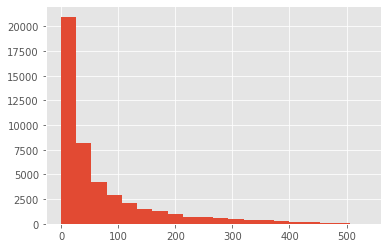

In [407]:
last_diff.hist(bins=20)

看一下直方图，典型的长尾分布，大部分用户的消费间隔确实比较短。不妨将时间召回点设为消费后立即赠送优惠券，消费后10天询问用户CD怎么样，消费后30天提醒优惠券到期，消费后60天短信推送。这便是数据的应用了

若想要追求更好的Python技术，可以把上述的分析过程都封装成函数。当下次想要再次分析的时候，怎么样只用几个函数就搞定，而不是继续重复码代码。

这里的数据只是用户ID，消费时间，购买量和消费金额。如果换成用户ID，浏览时间，浏览量，能不能直接套用？浏览变成评论、点赞又行不行？消费行为变成用户其他行为呢？我可以明确地告诉你，大部分代码只要替换部分就能直接用了。